# Consumer Price Index analysis

By Ben Welsh

A rudimentary analysis of the Consumer Price Index published by the U.S. Bureau of Labor Statistics. It was developed to verify the accuracy of the [cpi](https://github.com/datadesk/cpi) open-source Python wrapper that eases access to the official government data. 

### Import Python tools

In [1]:
import os
import json
import warnings
import pandas as pd
import altair as alt
from datetime import date, datetime, timedelta

In [2]:
import altair_latimes as lat

In [3]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [4]:
warnings.simplefilter("ignore")

### Import the development version of this library

In [5]:
import os
import sys
this_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, this_dir)
import cpi

## Top-level numbers for the latest month

In [6]:
def get_last13(**kwargs):
    df = cpi.series.get(**kwargs).to_dataframe()
    # Filter down to monthly values
    df = df[df.period_type == 'monthly']
    # Cut down to the last 13 months
    df = df.sort_values("date").tail(14)
    # Return it
    return df

In [7]:
def analyze_last13(df):
    # Calculate the monthly percentage change
    df['pct_change'] = (df.value.pct_change()*100)
    # Calculate the monthly percentage change
    df['pct_change_rounded'] = df['pct_change'].round(1)
    # Get latest months
    latest_month, latest_change = df.sort_values("date", ascending=False)[['date', 'pct_change_rounded']].to_records(index=False)[0]
    previous_month, previous_change = df.sort_values("date", ascending=False)[['date', 'pct_change_rounded']].to_records(index=False)[1]
    # Pass it back
    return dict(
        latest_month=latest_month,
        latest_change=latest_change,
        previous_month=previous_month,
        previous_change=previous_change,
    )

Query the seasonally-adjusted CPI-U, which is the variation used by the BLS in its release.

In [8]:
adjusted_cpiu_last13 = get_last13(seasonally_adjusted=True)

In [9]:
adjusted_cpi_analysis = analyze_last13(adjusted_cpiu_last13)

In [10]:
adjusted_cpi_analysis

{'latest_month': '2019-03-01',
 'latest_change': 0.4,
 'previous_month': '2019-02-01',
 'previous_change': 0.2}

In [11]:
adjusted_food_analysis = analyze_last13(get_last13(seasonally_adjusted=True, items="Food"))

In [12]:
adjusted_food_analysis

{'latest_month': '2019-03-01',
 'latest_change': 0.3,
 'previous_month': '2019-02-01',
 'previous_change': 0.4}

In [13]:
adjusted_energy_analysis = analyze_last13(get_last13(seasonally_adjusted=True, items="Energy"))

In [14]:
adjusted_energy_analysis

{'latest_month': '2019-03-01',
 'latest_change': 3.5,
 'previous_month': '2019-02-01',
 'previous_change': 0.4}

In [15]:
adjusted_all_less_food_and_energy_analysis = analyze_last13(get_last13(seasonally_adjusted=True, items="All items less food and energy"))

In [16]:
adjusted_all_less_food_and_energy_analysis

{'latest_month': '2019-03-01',
 'latest_change': 0.1,
 'previous_month': '2019-02-01',
 'previous_change': 0.1}

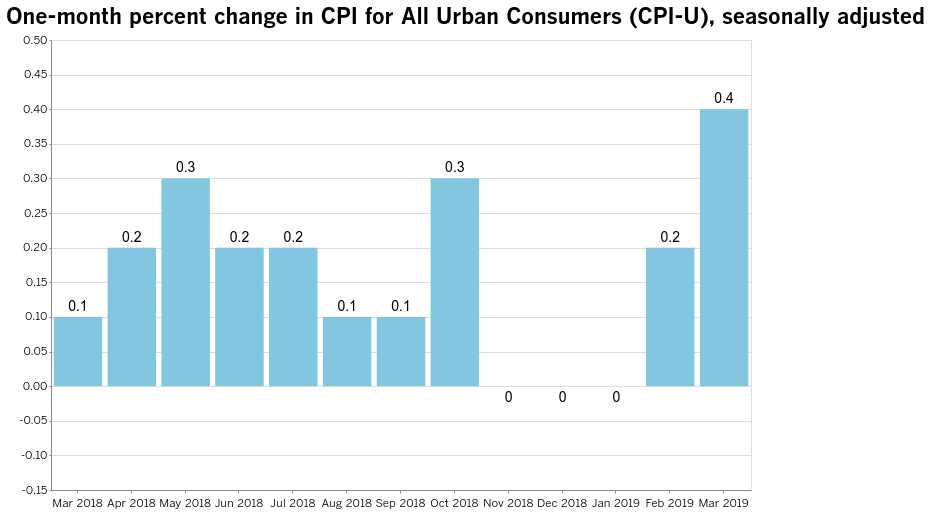

In [17]:
base = alt.Chart(
    adjusted_cpiu_last13, 
    title="One-month percent change in CPI for All Urban Consumers (CPI-U), seasonally adjusted"
).properties(width=700)

bars = base.mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="utcyearmonth",
        axis=alt.Axis(title=None, labelAngle=0),
    ),
    y=alt.Y(
        "pct_change_rounded:Q",
        axis=alt.Axis(title=None),
        scale=alt.Scale(domain=[
            adjusted_cpiu_last13['pct_change'].min()-0.1,
            adjusted_cpiu_last13['pct_change'].max()+0.05
        ])
    )
)

text = base.encode(
    x=alt.X("date:O", timeUnit="utcyearmonth"),
    y="pct_change_rounded:Q",
    text='pct_change_rounded'
)

textAbove = text.transform_filter(alt.datum.pct_change > 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=-10
)

textBelow = text.transform_filter(alt.datum.pct_change < 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=12
)

bars + textAbove + textBelow

Get the year over year change

In [18]:
unadjusted_cpiu = cpi.series.get(seasonally_adjusted=False).to_dataframe()

In [19]:
unadjusted_cpiu_monthly = unadjusted_cpiu[unadjusted_cpiu.period_type == 'monthly'].sort_values("date", ascending=False)

In [20]:
unadjusted_cpiu_monthly.head(13)[[
    'date',
    'value'
]]

,date,value
372,2019-03-01,254.202
371,2019-02-01,252.776
370,2019-01-01,251.712
369,2018-12-01,251.233
368,2018-11-01,252.038
367,2018-10-01,252.885
366,2018-09-01,252.439
365,2018-08-01,252.146
364,2018-07-01,252.006
363,2018-06-01,251.989


In [21]:
lastest_unadjusted, one_year_ago_unadjusted = pd.concat([
    unadjusted_cpiu_monthly.head(1),
    unadjusted_cpiu_monthly.head(13).tail(1),
]).value.tolist()

In [22]:
lastest_unadjusted, one_year_ago_unadjusted

(254.202, 249.554)

In [23]:
yoy_change = round(((lastest_unadjusted-one_year_ago_unadjusted)/one_year_ago_unadjusted)*100, 1)

In [24]:
yoy_change

1.9

In [25]:
with open("./latest.json", "w") as fp:
    fp.write(json.dumps(dict(
        all=adjusted_cpi_analysis,
        food=adjusted_food_analysis,
        energy=adjusted_energy_analysis,
        less_food_and_energy=adjusted_all_less_food_and_energy_analysis,
        yoy_change=yoy_change,
    )))

In [26]:
adjusted_cpiu_last13[~pd.isnull(adjusted_cpiu_last13.pct_change_rounded)][[
    'date',
    'pct_change',
    'pct_change_rounded'
]].to_csv("./cpi-mom.csv", index=False)

### Match category analysis published by the BLS

In an October 2018 [post](https://www.bls.gov/opub/ted/2018/consumer-prices-up-2-point-3-percent-over-year-ended-september-2018.htm) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers across a select group of categories. We will replicate it below.

![](https://i.imgur.com/54RcrID.png)

Query the data series charted by the BLS

In [27]:
all_items = cpi.series.get(seasonally_adjusted=False).to_dataframe()

In [28]:
energy = cpi.series.get(items="Energy", seasonally_adjusted=False).to_dataframe()

In [29]:
food = cpi.series.get(items="Food", seasonally_adjusted=False).to_dataframe()

Write a function to prepare each series for presentation

In [30]:
def prep_yoy(df):
    # Trim down to monthly values
    df = df[df.period_type == 'monthly']
    # Calculate percentage change year to year
    df['pct_change'] = df.value.pct_change(12)
    # Trim down to the last 13 months
    return df.sort_values("date")

In [31]:
all_items_prepped = prep_yoy(all_items)

In [32]:
energy_prepped = prep_yoy(energy)

In [33]:
food_prepped = prep_yoy(food)

In [34]:
three_cats = pd.concat([
    all_items_prepped.tail(12*10),
    energy_prepped.tail(12*10),
    food_prepped.tail(12*10)
])

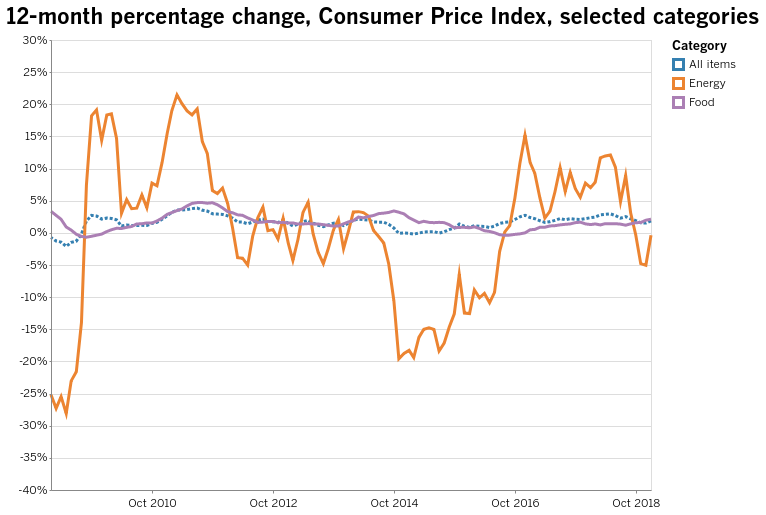

In [35]:
base = alt.Chart(
    three_cats,
    title="12-month percentage change, Consumer Price Index, selected categories"
).encode(
    x=alt.X(
        "date:T",
        timeUnit="yearmonth",
        axis=alt.Axis(
            title=None,
            labelAngle=0,
            grid=False,
            # A truly gnarly hack from https://github.com/altair-viz/altair/issues/187
            values=list(pd.to_datetime([
                '2008-11-01',
                '2010-11-01',
                '2012-11-01',
                '2014-11-01',
                '2016-11-01',
                '2018-11-01'
            ]).astype(int) / 10 ** 6)
        ),
    ),
    y=alt.Y(
        "pct_change:Q",
        axis=alt.Axis(title=None, format='%'),
        scale=alt.Scale(domain=[-0.4, 0.3])
    ),
    color=alt.Color(
        "series_items_name:N",
        legend=alt.Legend(title="Category"),
        # scale=alt.Scale(range=["#423a51", "#449cb0", "#d09972"])
    )
)

all_items = base.transform_filter(
    alt.datum.series_items_name == 'All items'
).mark_line(strokeDash=[3, 2])

other_items = base.transform_filter(
    alt.datum.series_items_name != 'All items'
).mark_line()

(all_items + other_items).properties(width=600)

In [36]:
three_cats.to_csv("./three-categories-yoy.csv", index=False)

### A similar chart with a shorter timeframe

Here's another one.

![](https://i.imgur.com/h1nA41O.png)

In [37]:
all_less_energy_and_food = cpi.series.get(items="All items less food and energy", seasonally_adjusted=False).to_dataframe()

In [38]:
all_less_energy_and_food_prepped = prep_yoy(all_less_energy_and_food)

In [39]:
two_cats = pd.concat([
    all_items_prepped.tail(13),
    all_less_energy_and_food_prepped.tail(13),
])

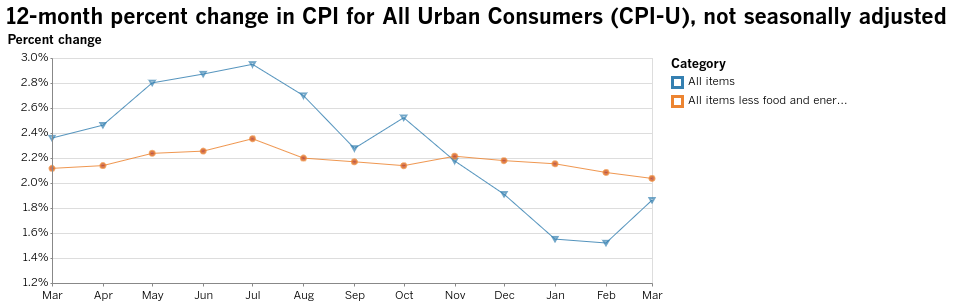

In [40]:
base = alt.Chart(
    two_cats,
    title="12-month percent change in CPI for All Urban Consumers (CPI-U), not seasonally adjusted"
).encode(
    x=alt.X(
        "date:T",
        timeUnit="utcyearmonth",
        axis=alt.Axis(
            title=None,
            labelAngle=0,
            grid=False,
            format="%b"
        )
    ),
    y=alt.Y(
        "pct_change:Q",
        axis=alt.Axis(title="Percent change", format='%'),
        scale=alt.Scale(domain=[0.012, 0.03])
    ),
    color=alt.Color(
        "series_items_name:N",
        legend=alt.Legend(title="Category"),
        # scale=alt.Scale(range=["#336EFF", "#B03A2E",])
    )
)

line = base.mark_line(strokeWidth=0.85)
exes = base.transform_filter(alt.datum.series_items_name == 'All items').mark_point(shape="triangle-down", size=25)
points = base.transform_filter(alt.datum.series_items_name == 'All items less food and energy').mark_point(size=25, fill="#B03A2E")

(line + exes + points).properties(width=600, height=225)

In [41]:
two_cats.to_csv("./two-categories-yoy.csv", index=False)